In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("final_processed_dataset.csv")
print(f"Loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns.")
df.head(0)

# filter to rows with a valid target
df_model = df.copy()
df_model = df_model[df_model["YoY_target"].notna()].copy()

# separate features and target
y = df_model["YoY_target"]
X = df_model.drop(columns=["YoY_target"])

# drop rows with missing values
X = X.dropna()
y = y.loc[X.index]

X.head(0)


Loaded dataset with 3009 rows and 139 columns.


,ZIP,Year,StateSizeRank,FinalZHVI,CAGR,AvgMonthlyGrowth,AvgYoYGrowth,MedianYoYGrowth,Volatility,NegativeGrowthYears,...,CountyName_Toombs,CountyName_Troup,CountyName_Walker,CountyName_Walton,CountyName_Ware,CountyName_Washington,CountyName_Wayne,CountyName_Whitfield,CountyName_Wilkes,CountyName_Worth


## To make sure the model does not learn the target from previous years we split it by zip so it can not leak target.

In [2]:
# split ZIPs and apply group-based train/test split
unique_zips = X["ZIP"].unique()
train_zips, test_zips = train_test_split(unique_zips, test_size=0.2, random_state=42)

# apply mask to split by ZIP
train_mask = X["ZIP"].isin(train_zips)
X_train_raw = X[train_mask].copy()
X_test_raw = X[~train_mask].copy()
X_train = X_train_raw.drop(columns=["ZIP"])
X_test = X_test_raw.drop(columns=["ZIP"])

y_train = y[train_mask]
y_test = y[~train_mask]

# scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("ZIP-based data split and scaling complete.")
print(f"Train set: {X_train.shape[0]} rows")
print(f"Test set: {X_test.shape[0]} rows")


ZIP-based data split and scaling complete.
Train set: 2383 rows
Test set: 626 rows


In [3]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import pandas as pd

# f_regression
selector_f = SelectKBest(score_func=f_regression, k=20)
X_train_f = selector_f.fit_transform(X_train_scaled, y_train)
X_test_f = selector_f.transform(X_test_scaled)

scores_f = selector_f.scores_
features_f = X_train.columns

top_f = pd.DataFrame({
    "Feature": features_f,
    "Score": scores_f
}).sort_values(by="Score", ascending=False).head(20)

print("Top 20 features (f_regression):")
print(top_f.to_string(index=False))


# mutual_info
selector_mi = SelectKBest(score_func=mutual_info_regression, k=20)
X_train_mi = selector_mi.fit_transform(X_train_scaled, y_train)
X_test_mi = selector_mi.transform(X_test_scaled)

scores_mi = selector_mi.scores_
features_mi = X_train.columns

top_mi = pd.DataFrame({
    "Feature": features_mi,
    "Score": scores_mi
}).sort_values(by="Score", ascending=False).head(20)

print("\nTop 20 features (mutual_info_regression):")
print(top_mi.to_string(index=False))

# shared top features
shared_features = set(top_f["Feature"]) & set(top_mi["Feature"])
print(f"\nShared features between both methods ({len(shared_features)}):")
print(sorted(shared_features))


Top 20 features (f_regression):
                                   Feature      Score
                              YoY_LastYear 597.281636
                                Volatility 297.356763
                                 FinalZHVI 154.221033
                              AvgYoYGrowth 143.323660
Metro_Atlanta-Sandy Springs-Alpharetta, GA 119.652098
                                      CAGR 115.712371
                          AvgMonthlyGrowth 110.854006
                        CountyName_Clayton  47.487685
                                      Year  40.572081
                        Metro_Valdosta, GA  31.929599
                        CountyName_Lowndes  31.929599
                      CountyName_Dougherty  24.162166
                         CountyName_Dekalb  22.490908
                        CountyName_Liberty  21.717337
                      Metro_Hinesville, GA  21.717337
                             Pct_Age_18_34  21.039278
                     Metro_Columbus, GA-AL  20.603

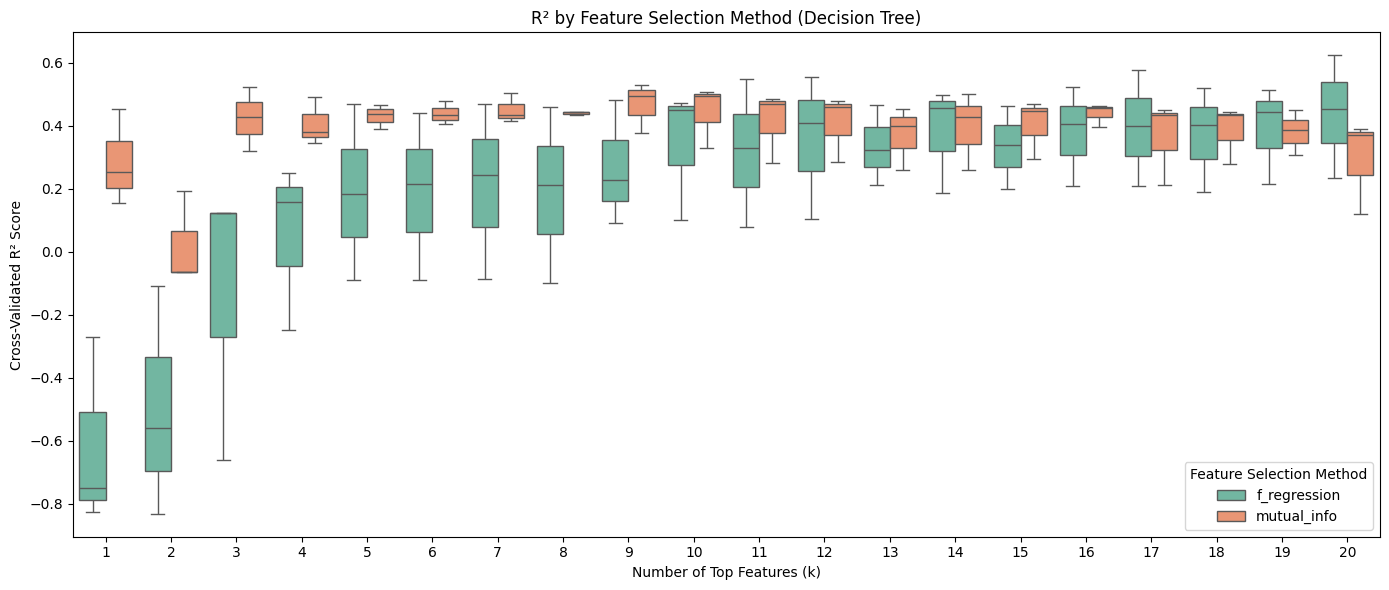

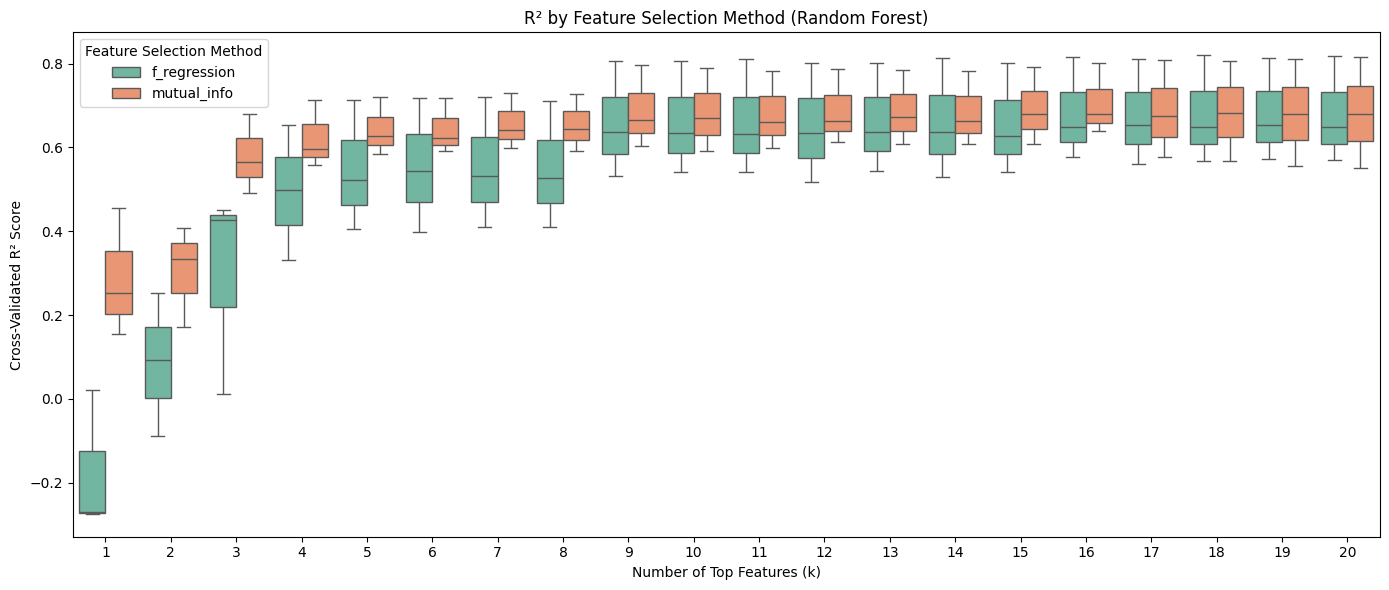

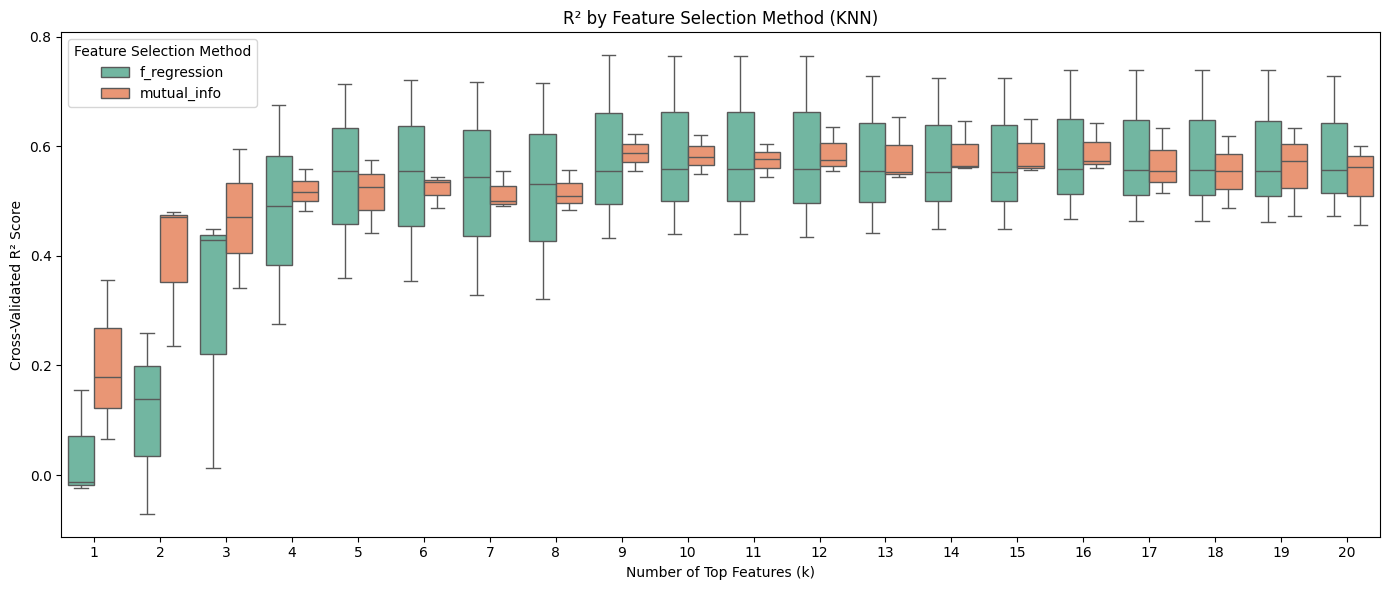

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

# settings
max_k = 20

models = {
    "Decision Tree": DecisionTreeRegressor,
    "Random Forest": RandomForestRegressor,
    "KNN": KNeighborsRegressor
}

for model_name, model_class in models.items():
    plot_data = []

    for k in range(1, max_k + 1):
        # f_regression
        sel_f = SelectKBest(score_func=f_regression, k=k)
        X_k_f = sel_f.fit_transform(X_train_scaled, y_train)
        model = model_class()
        scores = cross_val_score(model, X_k_f, y_train, cv=3, scoring="r2")
        for score in scores:
            plot_data.append({
                "R²": score, "k": k,
                "Method": "f_regression"
            })

        # mutual_info
        sel_mi = SelectKBest(score_func=mutual_info_regression, k=k)
        X_k_mi = sel_mi.fit_transform(X_train_scaled, y_train)
        model = model_class()
        scores = cross_val_score(model, X_k_mi, y_train, cv=3, scoring="r2")
        for score in scores:
            plot_data.append({
                "R²": score, "k": k,
                "Method": "mutual_info"
            })

    # create DataFrame and plot
    plot_df = pd.DataFrame(plot_data)

    plt.figure(figsize=(14, 6))
    sns.boxplot(data=plot_df, x="k", y="R²", hue="Method", palette="Set2")
    plt.title(f"R² by Feature Selection Method ({model_name})")
    plt.xlabel("Number of Top Features (k)")
    plt.ylabel("Cross-Validated R² Score")
    plt.legend(title="Feature Selection Method")
    plt.tight_layout()
    plt.show()


Based on the boxplots above I chose:
- Decision tree: 8 features
- Random forest: 16 features
- KNN: 9 features

because they show the highest mean r2 score and the boxplot is nice and compressed showing it did not vary much which is good.

best parameters for KNN: {'n_neighbors': 5, 'weights': 'distance'}
best parameters for RF: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


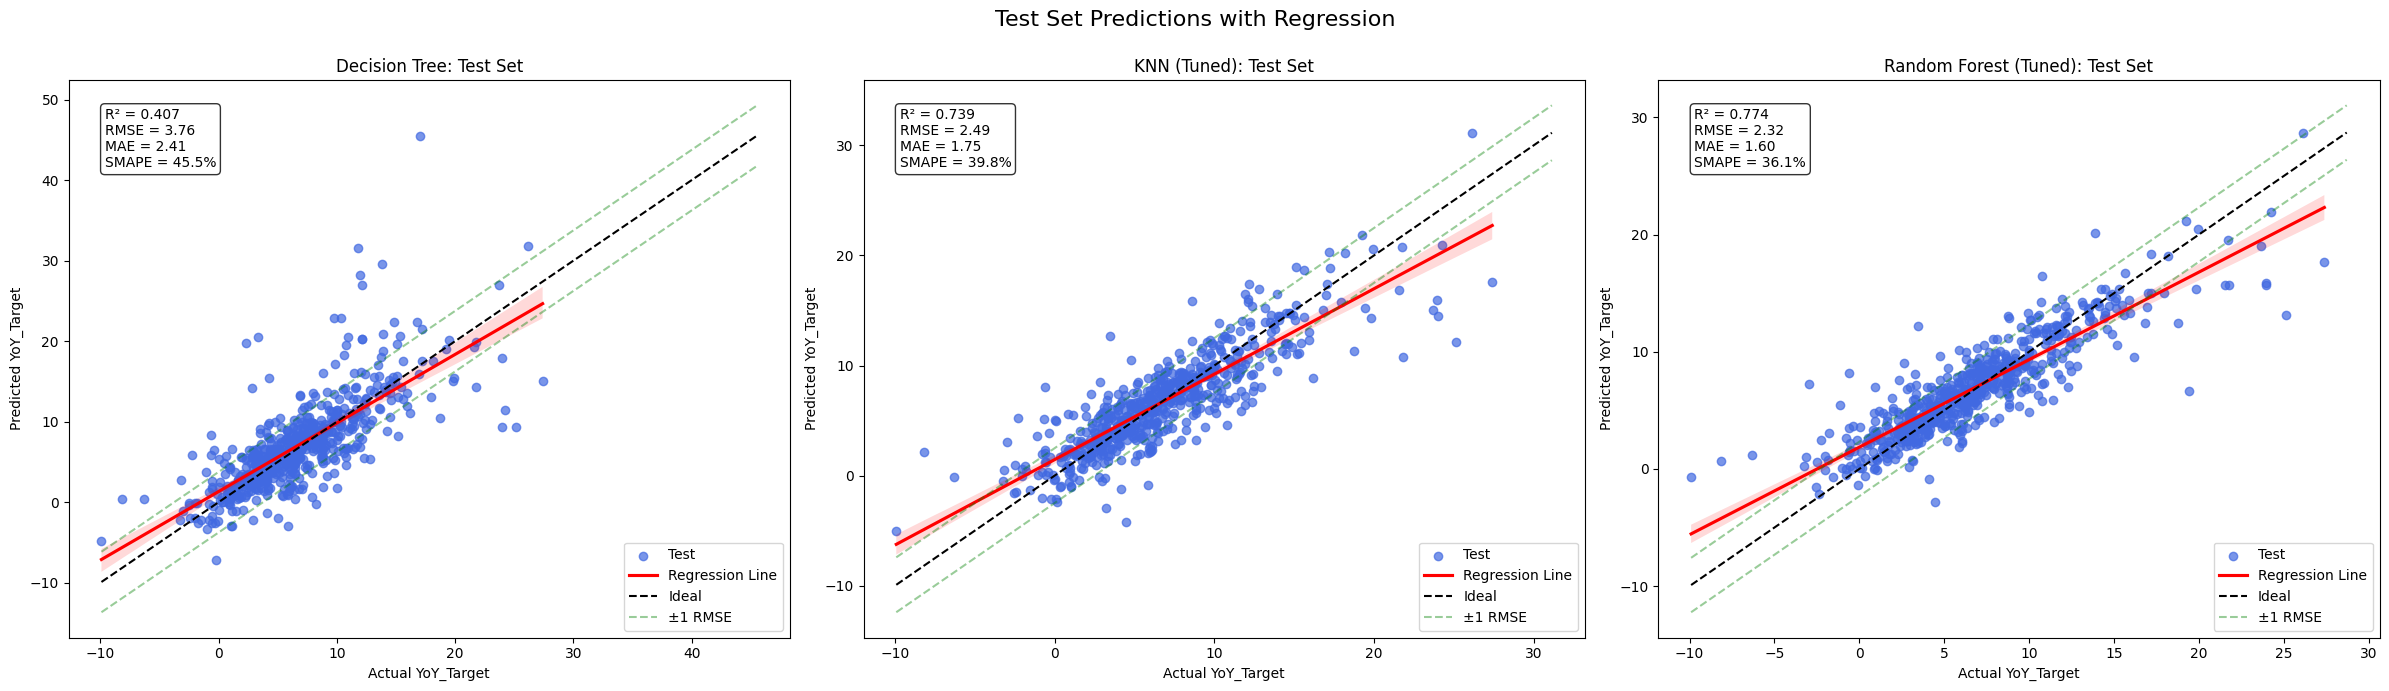

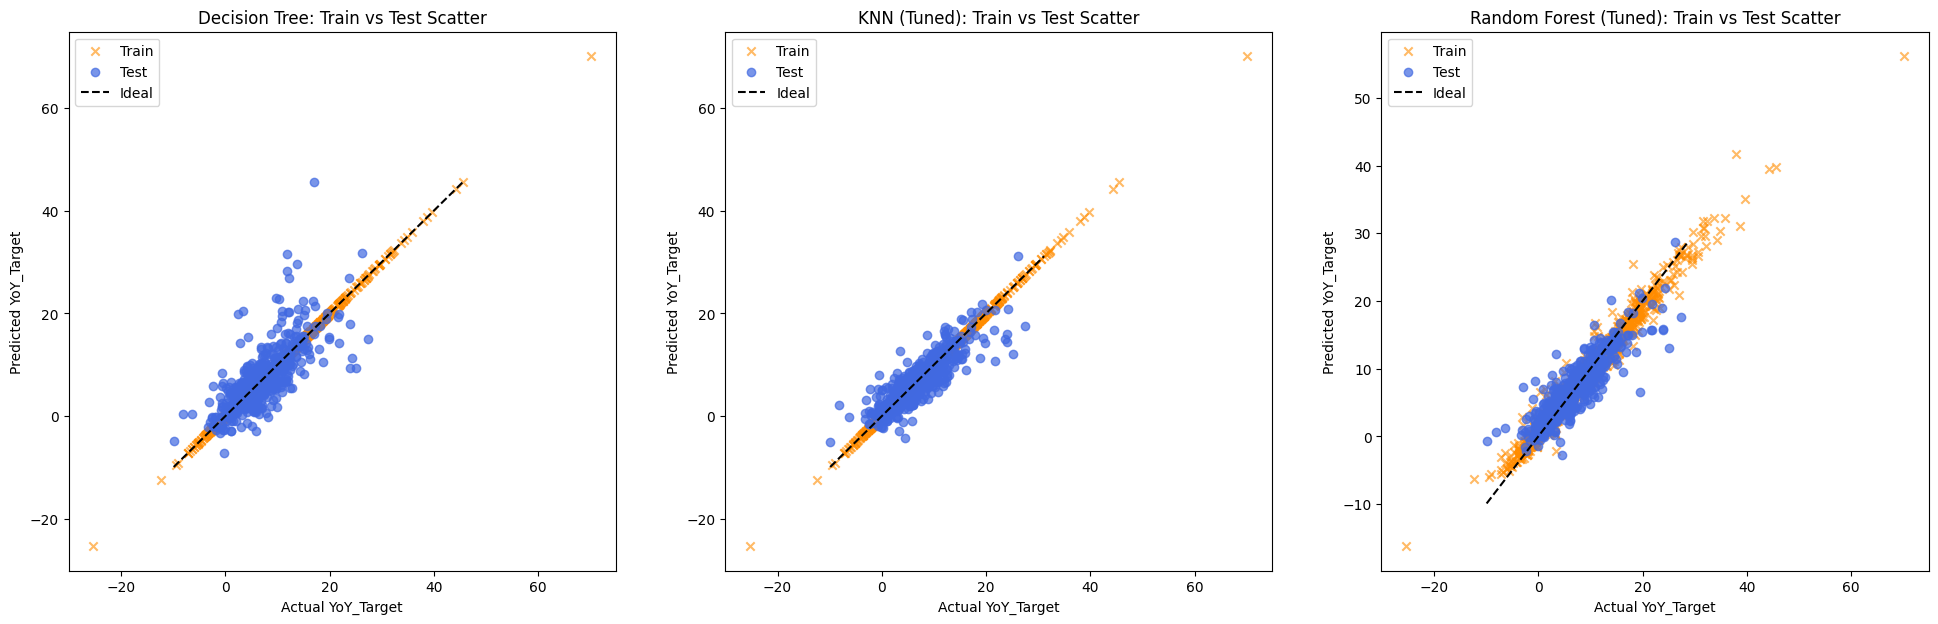

In [5]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# helper
def evaluate(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    smape_vals = np.abs(y_true - y_pred) / np.where(denominator == 0, 1, denominator)
    smape = 100 * np.mean(smape_vals)
    return r2, rmse, mae, smape

model_configs = {
    "Decision Tree": (DecisionTreeRegressor(random_state=42), 8),
    "KNN (Tuned)": ("gridsearch_knn", 9),
    "Random Forest (Tuned)": ("gridsearch_rf", 16)
}

results = []

fig1, axs1 = plt.subplots(1, 3, figsize=(24, 7))  # test set
fig2, axs2 = plt.subplots(1, 3, figsize=(24, 7))  # train set

for idx, (name, (model, k_features)) in enumerate(model_configs.items()):
    selector = SelectKBest(score_func=mutual_info_regression, k=k_features)
    X_train_sel = selector.fit_transform(X_train_scaled, y_train)
    X_test_sel = selector.transform(X_test_scaled)

    if model == "gridsearch_rf":
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
        base = RandomForestRegressor(random_state=42)
        grid_search = GridSearchCV(base, param_grid, cv=3, scoring='r2', n_jobs=-1)
        grid_search.fit(X_train_sel, y_train)
        model = grid_search.best_estimator_
        print(f"best parameters for RF: {grid_search.best_params_}")

    elif model == "gridsearch_knn":
        param_grid = {
            'n_neighbors': [5, 6, 7],
            'weights': ['uniform', 'distance']
        }
        base = KNeighborsRegressor()
        grid_search = GridSearchCV(base, param_grid, cv=3, scoring='r2', n_jobs=-1)
        grid_search.fit(X_train_sel, y_train)
        model = grid_search.best_estimator_
        print(f"best parameters for KNN: {grid_search.best_params_}")

    model.fit(X_train_sel, y_train)
    y_test_pred = model.predict(X_test_sel)
    y_train_pred = model.predict(X_train_sel)
    r2, rmse, mae, smape = evaluate(y_test.values, y_test_pred)
    results.append((name, r2, rmse, mae, smape))

    # Test Set Predictions
    ax = axs1[idx]
    ax.scatter(y_test, y_test_pred, color='royalblue', label="Test", alpha=0.7)
    sns.regplot(x=y_test, y=y_test_pred, scatter=False, color='red', ax=ax, label="Regression Line")

    lims = [min(y_test.min(), y_test_pred.min()), max(y_test.max(), y_test_pred.max())]
    ax.plot(lims, lims, 'k--', label='Ideal')
    ax.plot(lims, [l + rmse for l in lims], 'g--', alpha=0.4, label='±1 RMSE')
    ax.plot(lims, [l - rmse for l in lims], 'g--', alpha=0.4)
    ax.set_title(f"{name}: Test Set")
    ax.set_xlabel("Actual YoY_Target")
    ax.set_ylabel("Predicted YoY_Target")
    ax.legend()

    metrics_text = f"R² = {r2:.3f}\nRMSE = {rmse:.2f}\nMAE = {mae:.2f}\nSMAPE = {smape:.1f}%"
    ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes,
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Train vs Test
    ax2 = axs2[idx]
    ax2.scatter(y_train, y_train_pred, alpha=0.6, marker='x', color='darkorange', label='Train')
    ax2.scatter(y_test, y_test_pred, alpha=0.7, marker='o', color='royalblue', label='Test')
    ax2.plot(lims, lims, 'k--', label='Ideal')
    ax2.set_title(f"{name}: Train vs Test Scatter")
    ax2.set_xlabel("Actual YoY_Target")
    ax2.set_ylabel("Predicted YoY_Target")
    ax2.legend()

fig1.suptitle("Test Set Predictions with Regression", fontsize=16)
fig1.tight_layout()
fig1.subplots_adjust(top=0.88)
plt.show()

fig2.suptitle("Train vs Test Scatter", fontsize=16)
fig2.tight_layout()
fig2.subplots_adjust(top=0.88)
plt.show()
